In [2]:
import torch
import pickle

import sys
sys.path.append('..')

from Data import load_and_prepare_dataset_for_layoutLM
from transformers import LayoutLMForTokenClassification
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType , PeftModel
from Training import fine_tune_model, evaluate_model
from utils.utils import load_trained_lora_model

%load_ext autoreload
%autoreload 2

c:\Users\nicol\anaconda3\envs\Huggenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
id2label, label2id, train_dataloader, val_dataloader, test_dataloader = load_and_prepare_dataset_for_layoutLM(batch_size=2)

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')) # use 'cuda' instead of 'mps' if running on a GPU machine that is not provided by MacOS
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label),id2label=id2label, label2id=label2id)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'layoutlm.embeddings.word_embeddings.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Ablation study

We've seen that for the target modules [key, value] (default Lora config), the ideal r and alpha parameters were 8.

We keep those for this study as a baseline while also trying lower r values when we have more target modules and higher if we use only one

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

# Values for r and lora_alpha
lora_modules_to_r = {
    1: [1, 2, 4, 8, 16, 32, 64],
    2: [1, 2, 4, 8, 16, 32, 64],
    4: [1, 2, 4, 8, 16, 32, 64]
}
target_modules = [
    ['query'],
    ['key'],
    ['value'],
    ['query', 'key'],
    ['query', 'value'],
    ['value', 'key'],
    ['key', 'value', 'query', 'attention.output.dense'],
]
lora_alpha_normalized = 8
NUM_EXPERIMENTS = 10
results_list = []

for _ in range(NUM_EXPERIMENTS):

    # Store results for each model
    results_dict = {}
    def list_to_str(l):
        concatenated_str = str(l[0])
        if len(l) >= 2:
            if len(l) == 4:
                return 'ALL_MODULES'
            else:
                for el in l[1:]:
                    concatenated_str += '_'
                    concatenated_str += str(el)
        return concatenated_str

    for module_list in target_modules:
        for r in lora_modules_to_r[len(module_list)]:
            training_losses_list, val_losses_list, training_f1s_list, val_f1s_list, training_accs_list, val_accs_list = [], [], [], [], [], []
            print("######## Training with target_modules={} and r={} ########".format(module_list, r))
            lora_alpha = lora_alpha_normalized * r
            # Configure model
            model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
            peft_config = LoraConfig(
                task_type=TaskType.TOKEN_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, target_modules=module_list
            )
            model = get_peft_model(model, peft_config)
            print(model.print_trainable_parameters())
            optimizer = AdamW(params=model.parameters(),
                            lr=5e-4)
            scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

            training_losses, val_losses, training_f1s, val_f1s, training_accs, val_accs = fine_tune_model(
                model=model,
                device=device,
                optimizer=optimizer,
                scheduler=scheduler,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                id2label=id2label,
                num_epoch_max=20,
                early_stopping=False,
                test_frequency=1,
                model_folder='Lora_Fine_Tuning',
                model_name=f'Lora_modules_{module_list}_r_{r}'
            )

            training_losses_list.append(training_losses)
            val_losses_list.append(val_losses)
            training_f1s_list.append(training_f1s)
            val_f1s_list.append(val_f1s)
            training_accs_list.append(training_accs)
            val_accs_list.append(val_accs)

            model = load_trained_lora_model(id2label=id2label, label2id=label2id, r=r, path=f'../Saved_Models/Lora_Fine_Tuning/Best_Lora_modules_{module_list}_r_{r}.pth')

            results = evaluate_model(
                model=model,
                device=device,
                test_dataloader=test_dataloader,
                original_id2label=id2label
            )

            results['training_losses_list'] =  training_losses_list
            results['val_losses_list'] =  val_losses_list
            results['training_f1s_list'] =  training_f1s_list
            results['val_f1s_list'] =  val_f1s_list
            results['training_accs_list'] =  training_accs_list
            results['val_accs_list'] =  val_accs_list

            results_dict[(list_to_str(module_list), r)] = results
            print('\n')
    results_list.append(results_dict)
    with open('results_list_lora_ablation.pkl', 'wb') as f:
        pickle.dump(results_list, f)

In [6]:
# Concatenate with pre-existing result-list
try:
    with open('results_list_lora_ablation_all.pkl', 'rb') as f:
        all_results_list = pickle.load(f)
except:
    all_results_list = []

with open('results_list_lora_ablation.pkl', 'rb') as f:
        all_results_list.extend(pickle.load(f))

with open('results_list_lora_ablation_all.pkl', 'wb') as f:
        pickle.dump(all_results_list, f)

In [25]:
lora_modules_to_r = {
    1: [1, 2, 4, 8, 16, 32, 64],
    2: [1, 2, 4, 8, 16, 32, 64],
    4: [1, 2, 4, 8, 16, 32, 64]
}
target_modules = [
    ['query'],
    ['key'],
    ['value'],
    ['query', 'key'],
    ['query', 'value'],
    ['value', 'key'],
    ['key', 'value', 'query', 'attention.output.dense'],
]

def list_to_str(l):
        concatenated_str = str(l[0])
        if len(l) >= 2:
            if len(l) == 4:
                return 'ALL_MODULES'
            else:
                for el in l[1:]:
                    concatenated_str += '_'
                    concatenated_str += str(el)
        return concatenated_str

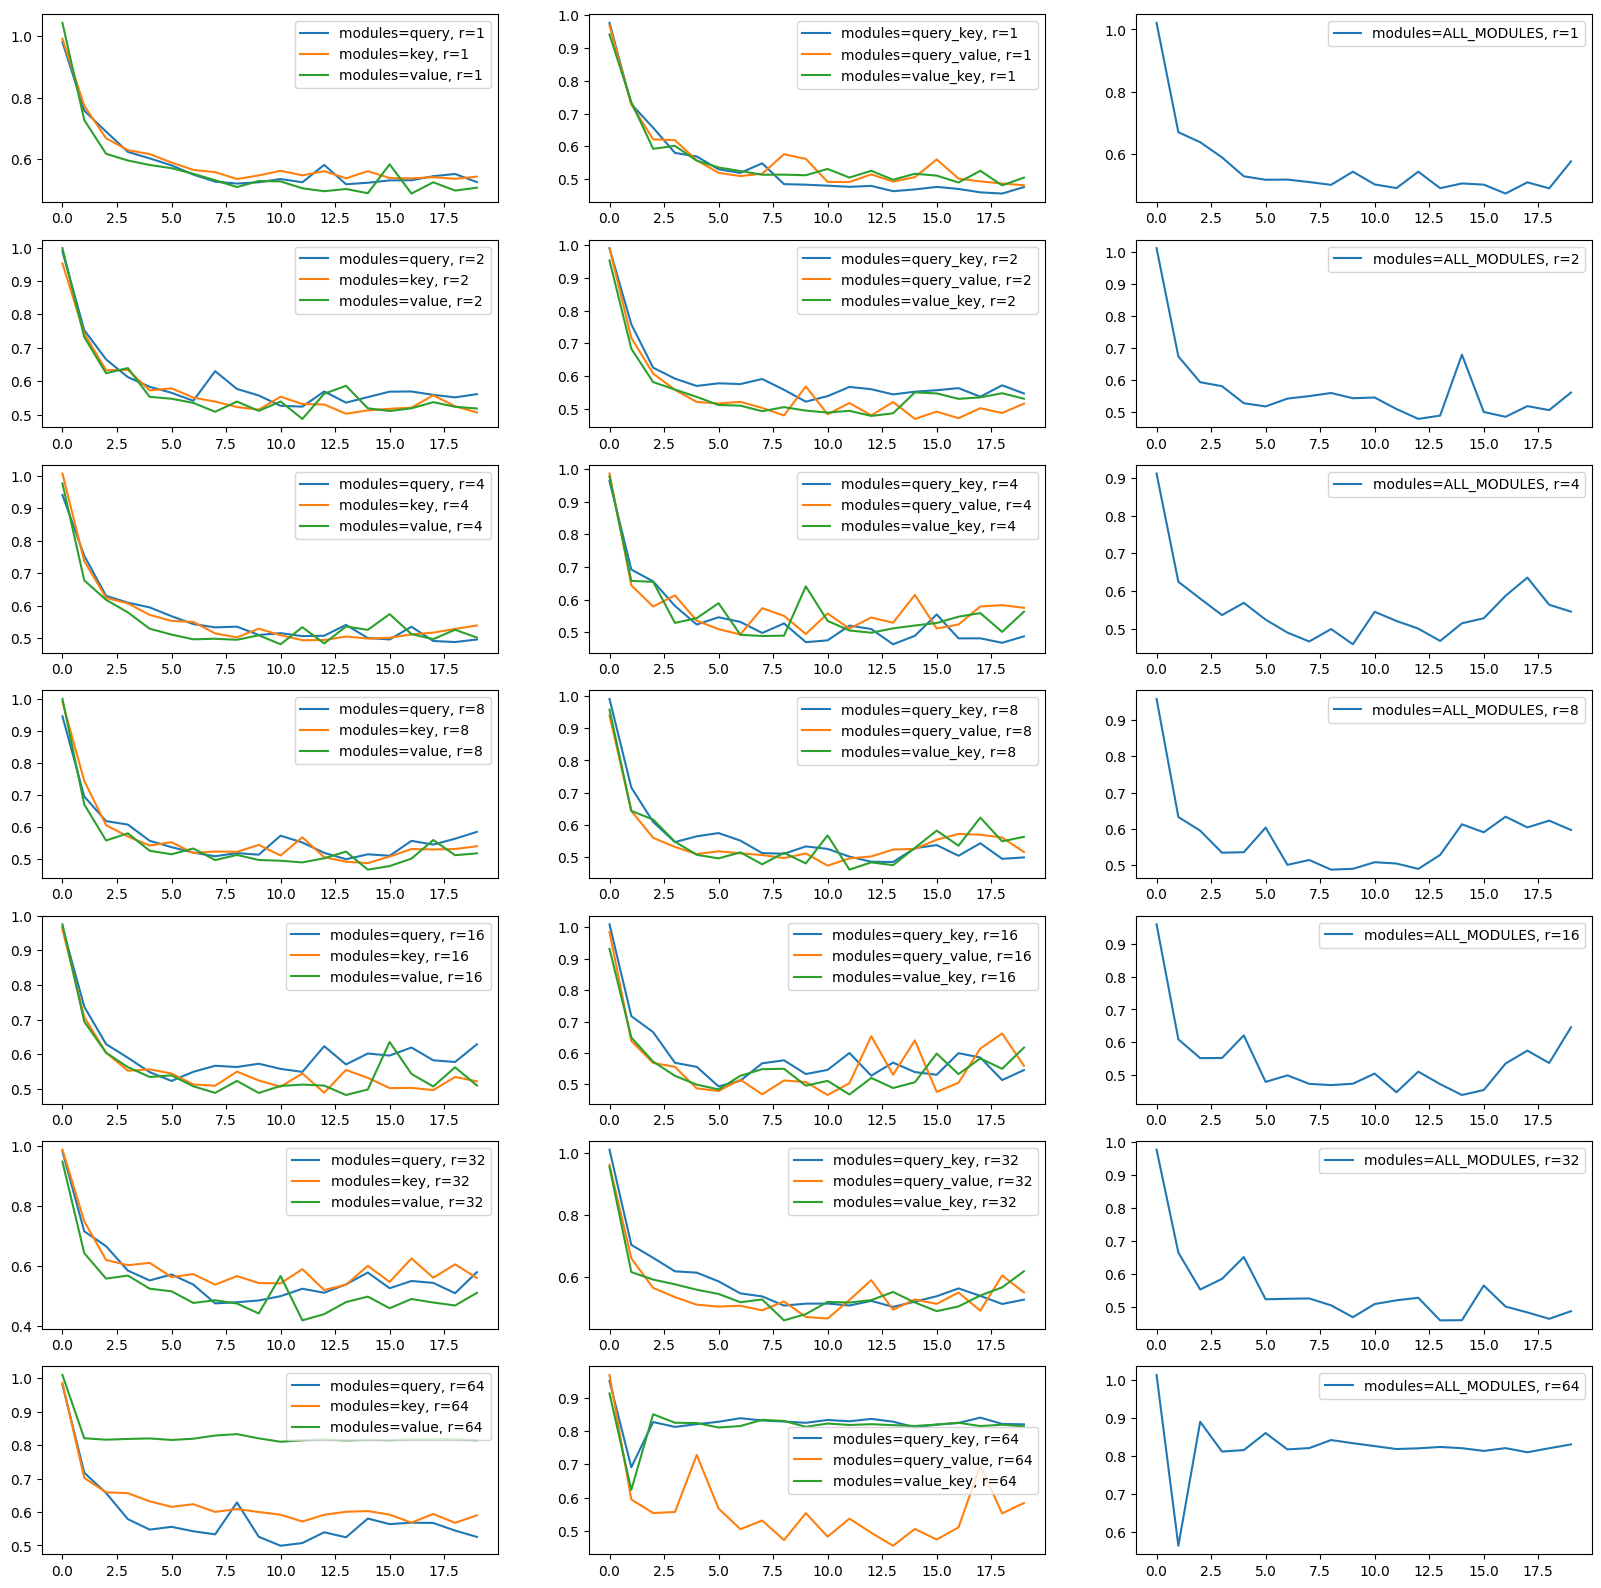

In [41]:
import matplotlib.pyplot as plt

LEN_MAPPING = {1: 0, 2: 1, 4: 2}
# Plot loss curves
fig, ax = plt.subplots(7, 3, figsize = (20, 20))
plt.style.use("default")
plt.grid(False)

result = all_results_list[-1]
for module_list in target_modules:
    for j, r in enumerate(lora_modules_to_r[len(module_list)]):
        ax[j, LEN_MAPPING[len(module_list)]].plot(result[(list_to_str(module_list), r)]["val_losses_list"][-1], label=f"modules={list_to_str(module_list)}, r={r}")
        ax[j, LEN_MAPPING[len(module_list)]].legend()

plt.show()

In [43]:
import pandas as pd

data = {}
results_dict = all_results_list[0]
for key, result in results_dict.items():
    data[key] = {}
    for metric in ['precision', 'recall', 'f1']:
        data[key][metric] = result[metric]

metrics_recap_df = pd.DataFrame(data=data)

In [44]:
metrics_recap_df

query                                                    \
                 1         2         4         8         16        32   
precision  0.595484  0.615359  0.613522  0.615752  0.674703  0.636200   
recall     0.654610  0.662057  0.736879  0.640426  0.724468  0.626950   
f1         0.623649  0.637854  0.669567  0.627846  0.698700  0.631541   

                          key                      ... value_key            \
                 64        1         2         4   ...        16        32   
precision  0.651908  0.632175  0.635703  0.647154  ...  0.651539  0.675379   
recall     0.605674  0.593617  0.589716  0.568440  ...  0.743262  0.632270   
f1         0.627941  0.612290  0.611847  0.605248  ...  0.694385  0.653114   

                    ALL_MODULES                                          \
                 64          1         2         4         8         16   
precision  0.450122    0.620022  0.680971  0.686154  0.686513  0.651958   
recall     0.656028    0.612766  0.686525  0.632624  0.740071  0.696809   
f1         0.533911    0.616372  0.683737  0.658303  0.712287  0.673637   

                               
                 32        64  
precision  0.554096  0.576282  
recall     0.702837  0.661702  
f1         0.619665  0.616045  

[3 rows x 49 columns]

<Axes: >

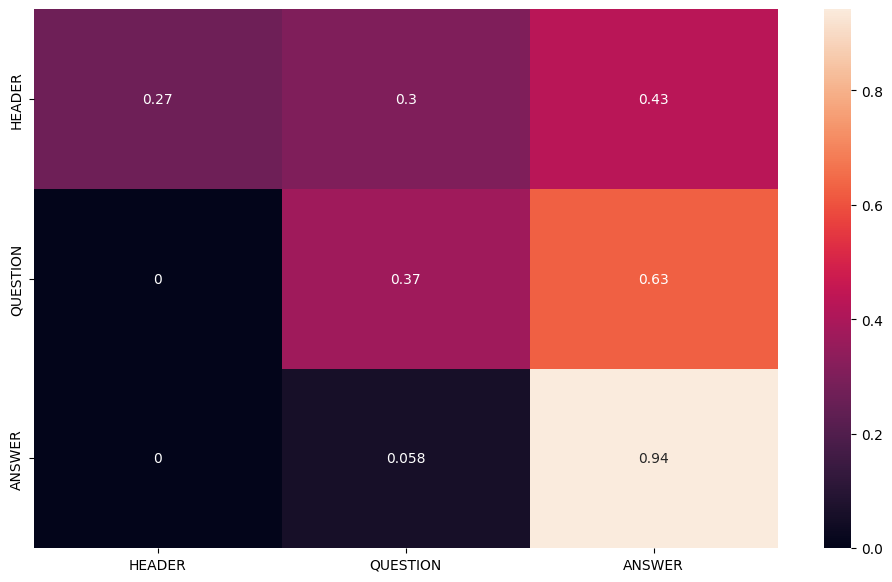

In [45]:
import seaborn as sn

plt.figure(figsize = (12,7))
sn.heatmap(result['conf_matrix_words'], annot=True)

<Axes: >

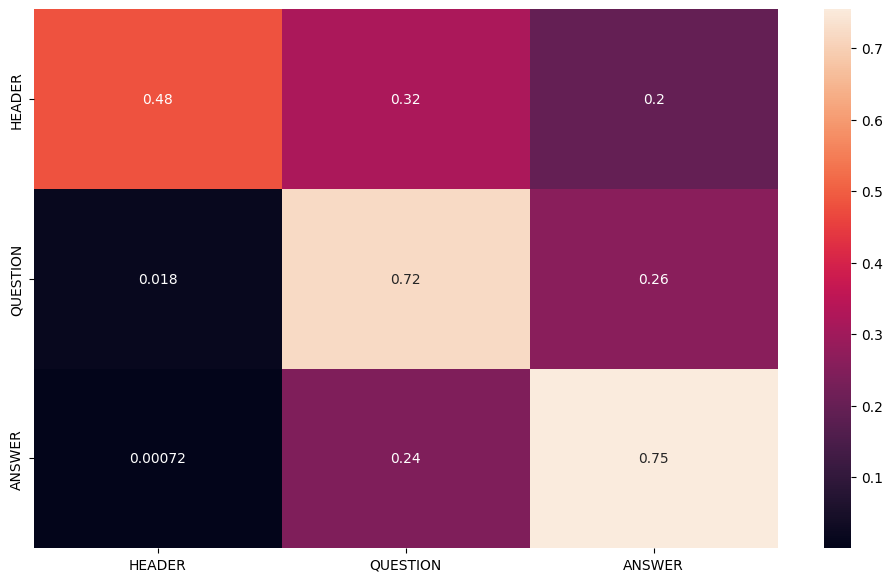

In [46]:
plt.figure(figsize = (12,7))
sn.heatmap(results_dict[('ALL_MODULES', 1)]['conf_matrix_words'], annot=True)